# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08

Clustering resources
- https://github.com/jrkreiger/instacart-analysis/blob/master/instacart-analysis.ipynb
- https://medium.com/towards-data-science/customer-segmentation-using-the-instacart-dataset-17e24be9c0fe


Other resources
- https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart

# NOTAS para adicionar
- EXPERIMENTAR DBSCAN
- feature selection (use variance)
- Eugenia Heatmap
- adicionar rate de compra de departments

Links datasets user and sample
sample: https://drive.google.com/file/d/1yWG47xO_8CLTdYIjo3k3007WxUgFpZjl/view?usp=sharing
total: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link
normal zip: https://drive.google.com/file/d/1l5lEv0nRKNvBbqmY7hQ23GBc1QnW6moR/view?usp=drive_link

# File and libraries

In [152]:
import pandas as pd
import numpy as np


filepath=r'data\instacart_pre_proc.csv'

file_tag = "Instacart Market Basket"


## DSLabs

In [153]:
%run "scripts/dslabs_functions.py"

## data functions

In [154]:
%run "scripts/data_functions.py"

data_functions lodaded


# Load

In [155]:
test_data=True
# test_data=False


# Define the sampling function
def sample_user_orders(data, fraction=0.1):
    # Get unique user_ids and order_ids
    unique_user_orders = data[['user_id', 'order_id']].drop_duplicates()
    sampled_user_orders = unique_user_orders.sample(frac=fraction)
    
    # Filter the dataset to include only the sampled users and orders
    sampled_data = data[data[['user_id', 'order_id']].apply(tuple, axis=1).isin(sampled_user_orders.apply(tuple, axis=1))]
    return sampled_data



if test_data==True:

    # Apply the sampling to each group 0.5%
    # sample=0.2

    # data=pd.read_csv(filepath)
    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc_sample.csv')
    # users_df=users_df.sample(frac=sample)



else:
    # Apply the sampling to each group 1%   
    # sample=0.1


    # data=pd.read_csv(filepath)

    # data = sample_user_orders(data, fraction=sample)

    users_df=pd.read_csv(r'data\instacart_user_pre_proc.csv')
    # users_df=users_df.sample(frac=sample)






users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41242 entries, 0 to 41241
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        41242 non-null  int64  
 1   total_orders                   41242 non-null  int64  
 2   mean_products                  41242 non-null  float64
 3   max_products                   41242 non-null  int64  
 4   std_num_products               41242 non-null  float64
 5   mean_lag_between_orders        41242 non-null  float64
 6   std_lag_between_orders         41242 non-null  float64
 7   mean_reorder_rate              41242 non-null  float64
 8   mean_weekend_order_rate        41242 non-null  float64
 9   mean_order_dow                 41242 non-null  float64
 10  top_order_dow                  41242 non-null  int64  
 11  order_dow_variety              41242 non-null  int64  
 12  top_order_hour                 41242 non-null 

## variable type definition

In [156]:
from pandas import Series, to_numeric, to_datetime


id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        elif c in id_cols:
            variable_types["id"].append(c)
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(users_df)
print(variable_types)


{'numeric': ['total_orders', 'mean_products', 'max_products', 'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order_rate', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'mean_peak_time_of_day_rate', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety'], 'binary': [], 'date': [], 'symbolic': [], 'id': ['user_id']}


# Cluster Data Prep

## drop nulls

- this will drop all first buying orders from the dataframe

In [157]:
# drop any null values
# data=data.dropna()

users_df=users_df.dropna()

## Remove Low Variance Features

In [158]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(users_df)

# Get selected features
selected_features = users_df.columns[selector.get_support()]
print(selected_features)

Index(['user_id', 'total_orders', 'mean_products', 'max_products',
       'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders',
       'mean_order_dow', 'top_order_dow', 'order_dow_variety',
       'top_order_hour', 'order_hour_variety', 'std_order_hour',
       'top_order_time_of_day_enc', 'order_time_of_day_enc_variety'],
      dtype='object')


In [159]:


numeric_vars = variable_types["numeric"]

# Print initial features
print("Initial features:\n", users_df.columns.tolist())

# Compute variance for each feature
feature_variance = users_df.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(users_df)

# Get selected features
initial_features = list(set(users_df.columns))
removed_features = list(set(users_df.columns) - set(selected_features))
selected_features = users_df.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['user_id', 'total_orders', 'mean_products', 'max_products', 'std_num_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_reorder_rate', 'mean_weekend_order_rate', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'mean_peak_time_of_day_rate', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety']

Feature Variance:
 user_id                          3.532269e+09
total_orders                     2.794175e+02
mean_products                    4.428012e+01
max_products                     1.041482e+02
std_num_products                 6.388554e+00
mean_lag_between_orders          5.192406e+01
std_lag_between_orders           1.064002e+01
mean_reorder_rate                4.515094e-02
mean_weekend_order_rate          4.710316e-02
mean_order_dow                   1.037048e+00
top_order_dow                    4.616989e+00
order_dow_variety                2.845217e+00
top_order_hour       

In [161]:
users_df = users_df[selected_features]

## Remove Redundant Variables
- Correlation interpretation - values between [-1,1]:
    - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
    - 0.7 to 0.9: Strong correlation.
    - 0.3 to 0.7: Moderate correlation.
    - 0.1 to 0.3: Weak correlation.
    - 0 to 0.1: No significant correlation.     

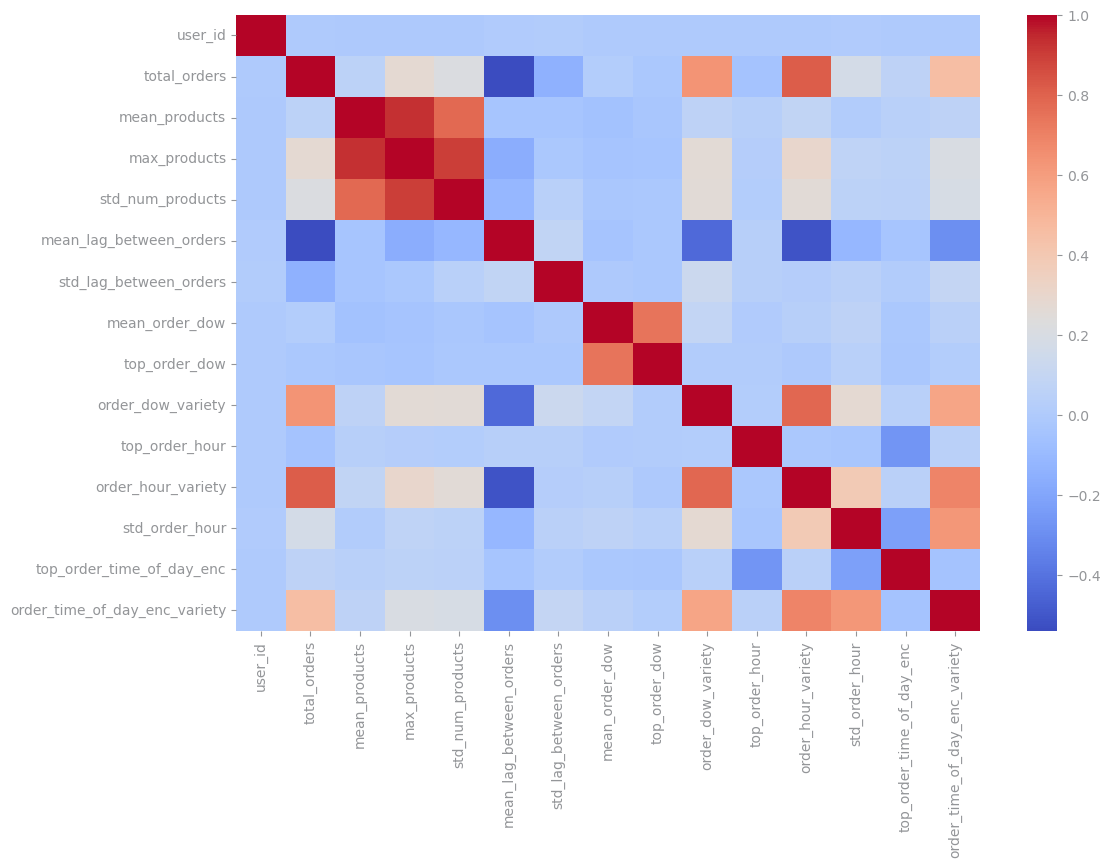

In [162]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = users_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [166]:
import numpy as np

# Calculate correlation matrix
corr_matrix = users_df.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.85:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(users_df.columns)}")

# Print redundant pairs
print(f"Redundant pairs (Too high Correlation):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features to drop: {to_drop}")




Initial number of features: 15
Redundant pairs (Too high Correlation):
mean_products and max_products: Correlation = 0.9336296152313405
max_products and std_num_products: Correlation = 0.899716904062768
Number of features dropped: 2
Features to drop: ['max_products', 'std_num_products']


In [167]:
# Drop the correlated features
users_df = users_df.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(users_df.columns)}")
print(f"Remaining features: {users_df.columns.tolist()}")

Remaining features: 13
Remaining features: ['user_id', 'total_orders', 'mean_products', 'mean_lag_between_orders', 'std_lag_between_orders', 'mean_order_dow', 'top_order_dow', 'order_dow_variety', 'top_order_hour', 'order_hour_variety', 'std_order_hour', 'top_order_time_of_day_enc', 'order_time_of_day_enc_variety']


## Drop outliers

In [169]:
variable_types: dict[str, list] = get_variable_types(users_df)

numeric_vars = variable_types["numeric"]

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,mean_lag_between_orders,std_lag_between_orders,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000,41242.000000
mean,15.643179,11.878678,15.415423,6.612661,2.746179,2.519228,4.686266,13.286456,7.207337,3.312760,1.671613,2.840745
std,16.715787,6.654331,7.205835,3.261905,1.018355,2.148718,1.686777,3.988021,3.888638,1.484343,1.743620,0.816556
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-1.570796,1.000000
25%,5.000000,7.074074,9.482759,4.225585,2.107143,1.000000,3.000000,10.000000,4.000000,2.299629,1.570796,2.000000
50%,9.000000,10.826087,14.625000,7.034149,2.750000,2.000000,5.000000,13.000000,6.000000,3.178782,1.570796,3.000000
75%,19.000000,15.494591,20.696234,9.024985,3.369565,5.000000,6.000000,16.000000,10.000000,4.162034,3.141593,3.000000
max,99.000000,61.189459,30.000000,21.213203,6.000000,6.000000,7.000000,23.000000,24.000000,11.519394,3.141593,4.000000


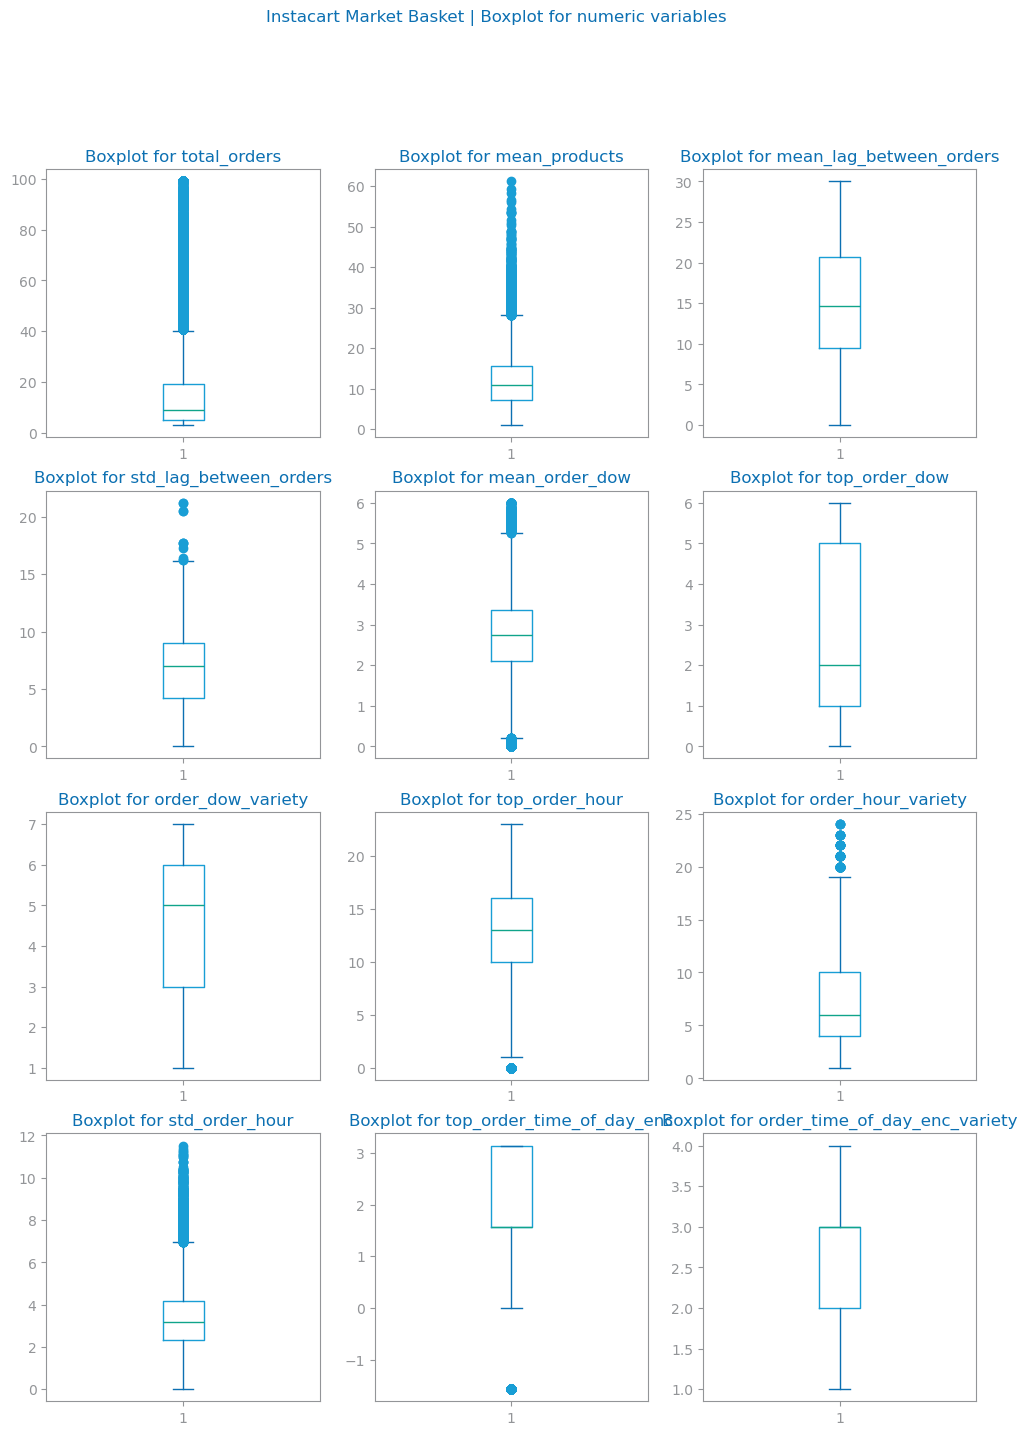

In [170]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

In [171]:



def truncate_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df[var] = np.where(df[var] < lower_bound, lower_bound, df[var])
			df[var] = np.where(df[var] > upper_bound, upper_bound, df[var])
	return df



def drop_numeric_outliers(df, summary, numeric_vars, factor=1):
	for var in numeric_vars:
		if var in summary.columns:
			std = summary[var]['std']
			mean = summary[var]['mean']
			lower_bound = mean - factor * std
			upper_bound = mean + factor * std
			df = df[(df[var] >= lower_bound) & (df[var] <= upper_bound)]
	return df



# users_df = truncate_outliers(users_df, summary5, numeric_vars)


outlier_drop = ['total_orders', 'mean_products','std_order_hour']
users_df = drop_numeric_outliers(users_df, summary5, outlier_drop)


users_df=users_df[users_df['total_orders']<=25]


# users_df = drop_numeric_outliers(users_df, summary5, numeric_vars)

summary5: DataFrame = users_df[numeric_vars].describe(include="all")
summary5

,total_orders,mean_products,mean_lag_between_orders,std_lag_between_orders,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,top_order_time_of_day_enc,order_time_of_day_enc_variety
count,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000,16559.000000
mean,10.212936,11.088767,16.447593,7.177353,2.729580,2.521167,4.531373,13.548946,6.436923,3.161035,1.724186,2.835014
std,6.017535,3.510174,6.591793,3.178730,1.044182,2.182355,1.521665,3.546203,2.622985,0.780969,1.785304,0.629107
min,3.000000,5.228571,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.828518,-1.570796,1.000000
25%,5.000000,8.170732,11.534683,5.170904,2.047906,0.000000,3.000000,11.000000,4.000000,2.518860,1.570796,2.000000
50%,9.000000,10.800000,16.018868,7.822749,2.727273,2.000000,5.000000,13.000000,6.000000,3.108645,3.141593,3.000000
75%,14.000000,13.777124,21.062829,9.472575,3.396689,5.000000,6.000000,16.000000,8.000000,3.757503,3.141593,3.000000
max,25.000000,18.532468,30.000000,15.811388,6.000000,6.000000,7.000000,23.000000,16.000000,4.795930,3.141593,4.000000


### New Outlier visualization

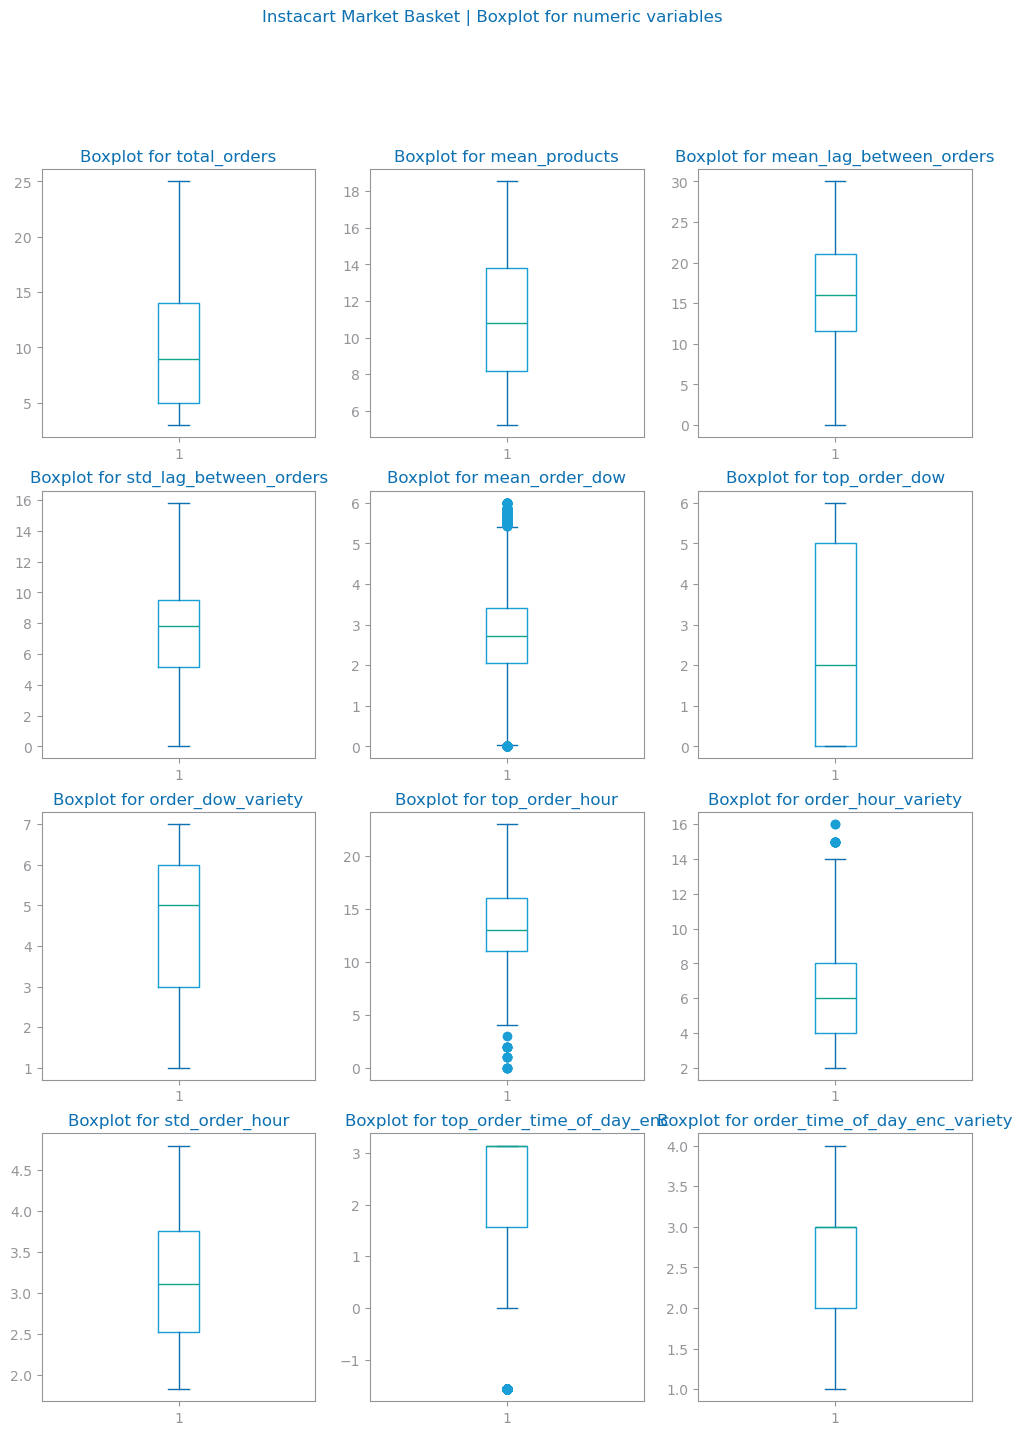

In [172]:
from numpy import ndarray
from matplotlib.figure import Figure
from matplotlib.pyplot import savefig, show, subplots
from dslabs_functions import define_grid, HEIGHT

if [] != numeric_vars:
    rows: int
    cols: int
    rows, cols = define_grid(len(numeric_vars))
    fig: Figure
    axs: ndarray
    title: f'{file_tag} Boxplot for numeric variables'
    fig, axs = subplots(
        rows, cols, figsize=(cols * HEIGHT, rows * HEIGHT), squeeze=False
    )
    
    fig.suptitle(f'{file_tag} | Boxplot for numeric variables')

    
    i, j = 0, 0
    for n in range(len(numeric_vars)):
        axs[i, j].set_title("Boxplot for %s" % numeric_vars[n])
        axs[i, j].boxplot(users_df[numeric_vars[n]].dropna().values)
        i, j = (i + 1, 0) if (n + 1) % cols == 0 else (i, j + 1)
    savefig(f"images/{file_tag}_single_boxplots.png")
    show()
else:
    print("There are no numeric variables.")

## User Order feature selection and scaling

In [173]:

from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
reorder_numeric_features = users_df[numeric_vars]

# Replace infinite values with NaN
reorder_numeric_features.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
reorder_numeric_features.dropna(inplace=True)

# Normalize the data
scaler = StandardScaler()
reorder_numeric_features_scaled = scaler.fit_transform(reorder_numeric_features)


# User Order KMEANS clustering

## User Order Elbow Method Studies

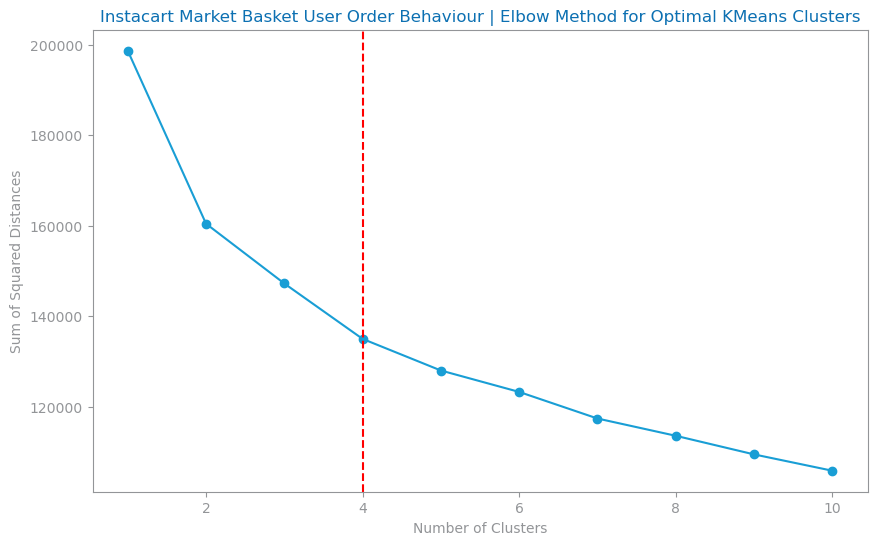

In [174]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 11))

# Initialize an empty list to store the sum of squared distances
ssd = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(reorder_numeric_features_scaled)
    ssd.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, ssd, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, ssd, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

## User Order Sillhouete study for kmeans

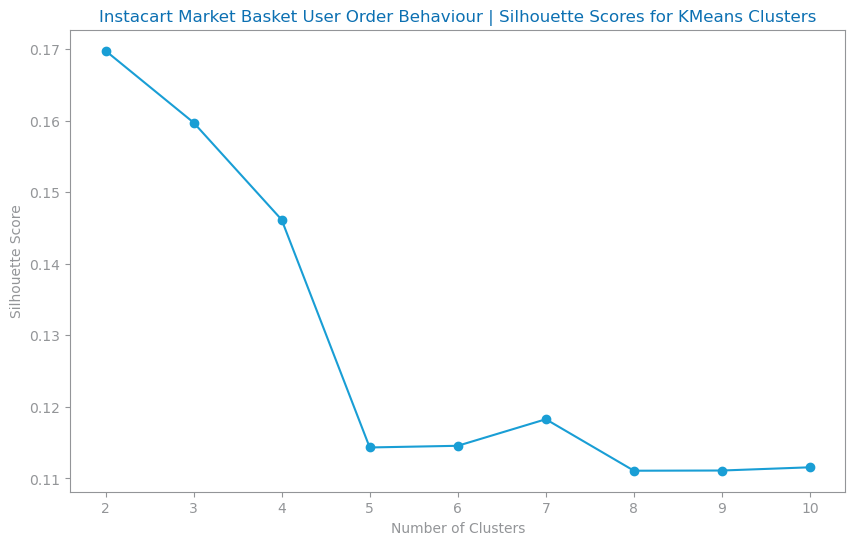

In [176]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 11))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(reorder_numeric_features_scaled)
    silhouette_avg = silhouette_score(reorder_numeric_features_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} User Order Behaviour | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

## User Order Kmeans model

In [177]:
# Clustering
reorder_kmeans = KMeans(n_clusters=4, random_state=42)
reorder_y_pred_kmeans = reorder_kmeans.fit_predict(reorder_numeric_features_scaled)

reorder_kmeans.cluster_centers_

array([[-0.61439637,  0.01357471,  0.34128482, -0.15793999, -0.80772751,
        -0.74899298, -0.64503224, -0.32514076, -0.62390354, -0.36518754,
         0.42433351, -0.50099812],
       [ 1.07748292,  0.06806422, -0.44817164,  0.22269527, -0.0117757 ,
        -0.09942872,  0.93661586, -0.09605291,  1.0645273 ,  0.36640991,
         0.21161939,  0.70031195],
       [-0.46755753, -0.02112711,  0.1832623 , -0.04356862,  0.01801582,
         0.02694573, -0.27431085,  1.21578569, -0.44739298,  0.20913335,
        -1.74176832, -0.06385613],
       [-0.52864308, -0.10348344,  0.12310076, -0.10947938,  0.99240873,
         1.04559131, -0.41863484, -0.3306562 , -0.51206139, -0.25281091,
         0.41346146, -0.39147803]])

# User Order Agglomerative

## User Order Sillouette Study for Agglomerative

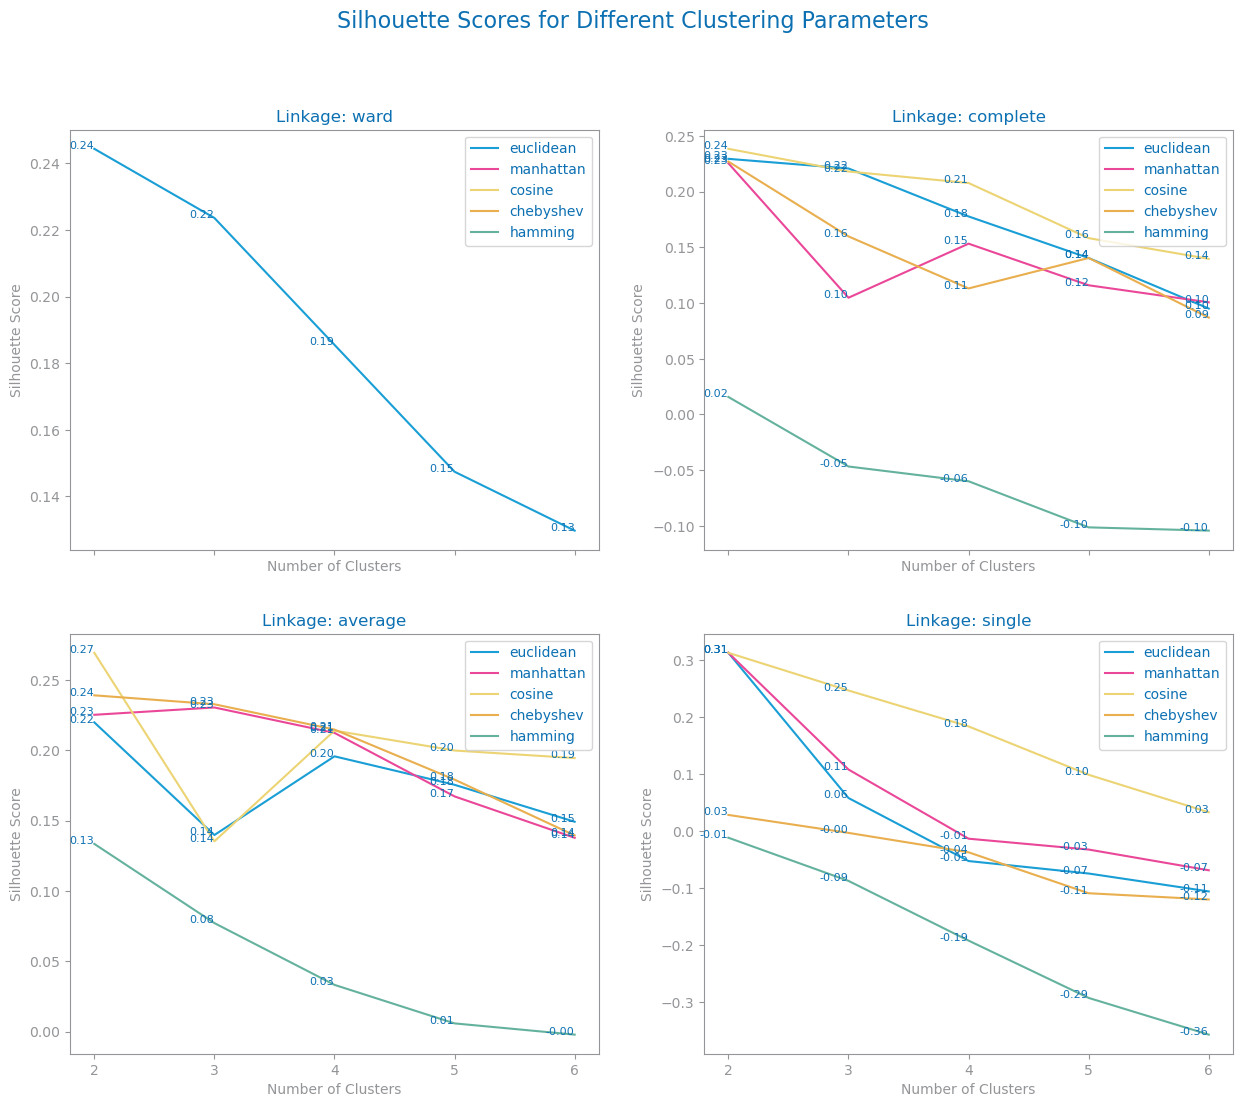

In [178]:
# Create a sample of the reorder_numeric features
reorder_numeric_features_sampled = reorder_numeric_features.sample(frac=0.2, random_state=42)

# Evaluate agglomerative clustering on the sampled data
evaluate_agglomerative_clustering(reorder_numeric_features_sampled, n_clusters_list=[2,3,4,5,6], scale='no')

## User Order Dendrogram

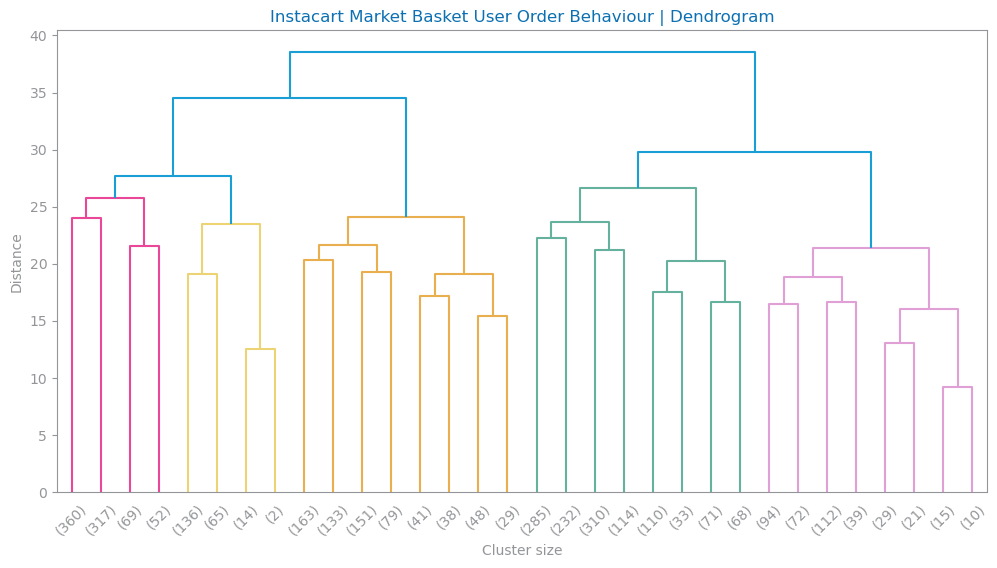

In [188]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(reorder_numeric_features_sampled, method='complete', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=4, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'descending'), 
plt.title(f'{file_tag} User Order Behaviour | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## User Order Agglomerative Model

In [198]:
reorder_agglo = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='complete' )
reorder_y_pred_agglo = reorder_agglo.fit_predict(reorder_numeric_features_scaled)

reorder_y_pred_agglo

array([0, 2, 1, ..., 0, 0, 2], dtype=int64)

# Final User Order Model Evaluation

In [199]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_kmeans)
silhouette_agglo = silhouette_score(reorder_numeric_features_scaled, reorder_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.1461544520955159
Silhouette Score for Agglomerative Clustering: 0.09816406908790044


## User Order Cluster Labeling

In [200]:
# Add cluster labels to the dataframe
users_df['kmeans_cluster'] = reorder_y_pred_kmeans
users_df['agglo_cluster'] = reorder_y_pred_agglo

# Map the cluster labels to custom names
cluster_mapping = {i: f'C{i+1}' for i in range(max(reorder_y_pred_kmeans.max(), reorder_y_pred_agglo.max()) + 1)}
users_df['kmeans_cluster'] = users_df['kmeans_cluster'].map(cluster_mapping)
users_df['agglo_cluster'] = users_df['agglo_cluster'].map(cluster_mapping)

# Display the dataframe with the new cluster labels
users_df.head()

,user_id,total_orders,mean_products,mean_lag_between_orders,std_lag_between_orders,mean_order_dow,top_order_dow,order_dow_variety,top_order_hour,order_hour_variety,std_order_hour,top_order_time_of_day_enc,order_time_of_day_enc_variety,kmeans_cluster,agglo_cluster
2,140839,10,8.432432,12.871429,4.232111,3.189189,2,6,9,7,3.972135,1.570796,3,C2,C1
3,153860,8,12.523810,22.596491,5.845816,2.269841,2,4,15,6,3.179717,3.141593,3,C1,C3
4,7396,8,7.641509,25.727273,5.946911,3.716981,6,5,15,6,2.537241,3.141593,3,C4,C2
10,131301,9,10.129412,9.000000,3.596294,2.247059,1,5,10,5,3.912094,1.570796,3,C1,C1
13,10725,11,14.723077,9.577236,3.226448,2.800000,1,5,16,6,2.606080,3.141593,3,C1,C1


### User Order Cluster Counts

In [201]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = users_df.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = users_df.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
C1    4566
C2    5587
C3    2678
C4    3728
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
C1    8176
C2    2988
C3    5395
dtype: int64


### User Order cluster boxplots

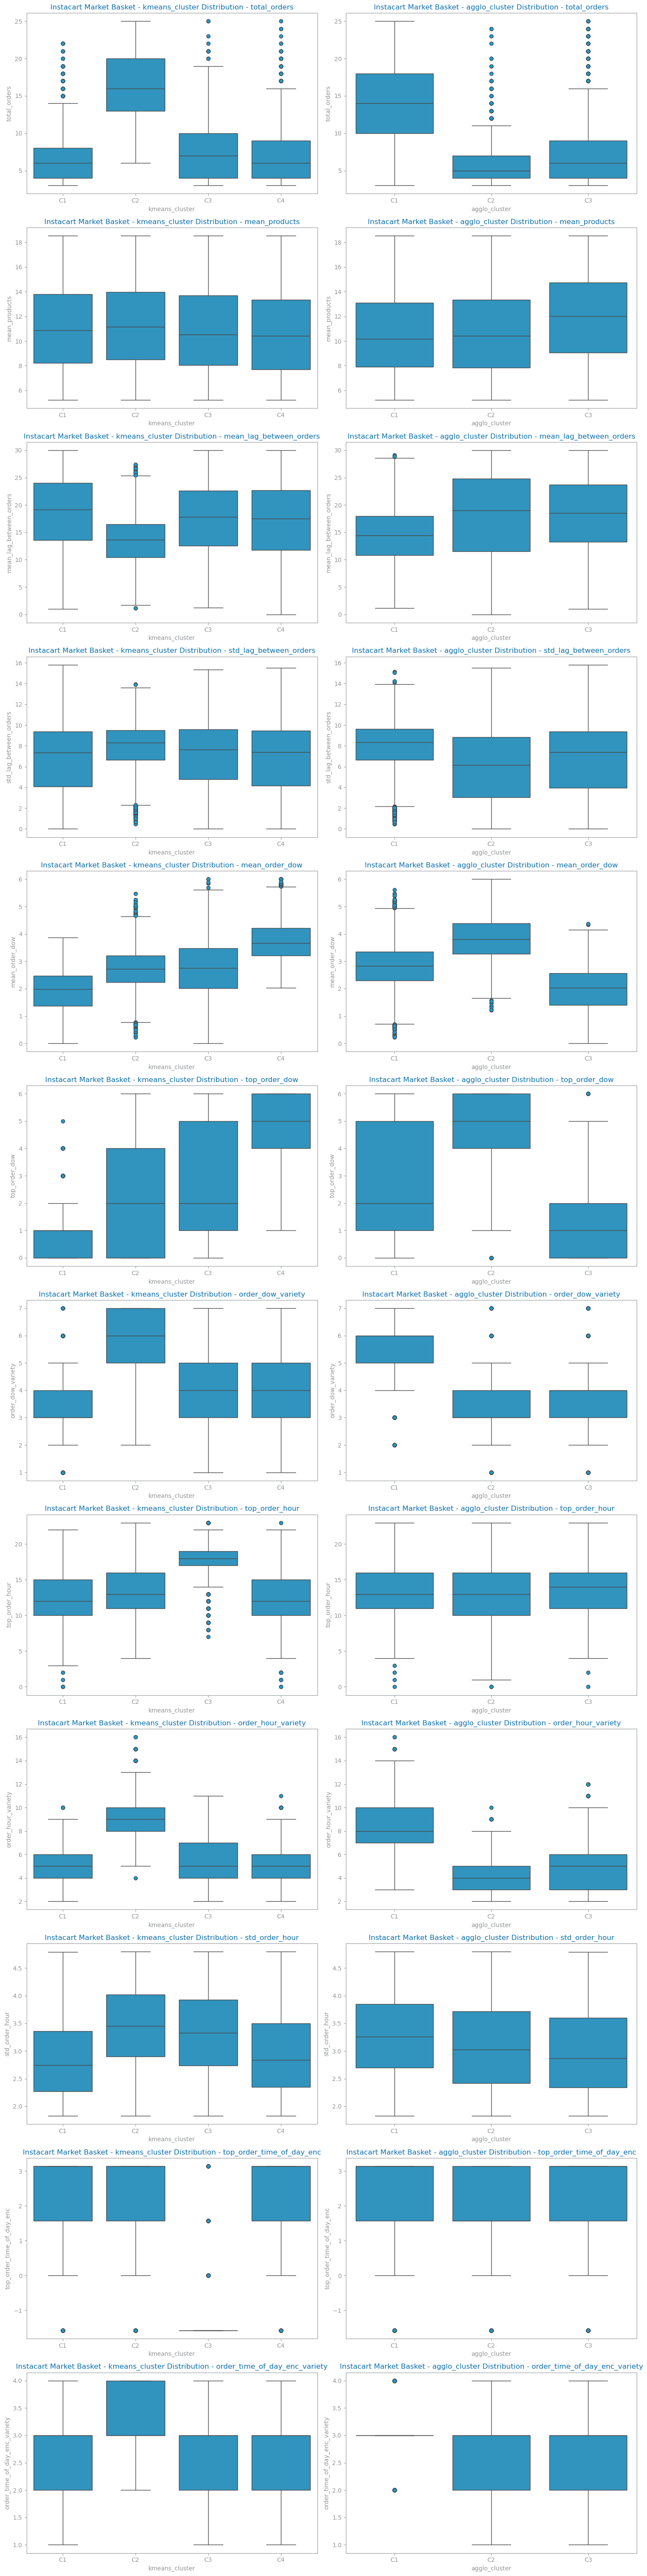

In [202]:

# Example usage
features = numeric_vars


cluster_labels = ['kmeans_cluster', 'agglo_cluster']
plot_cluster_boxplots(users_df, features, cluster_labels,file_tag=file_tag)

## User Order PCA visualization

In [203]:
from sklearn.decomposition import PCA

# Visualization
pca_reorder = PCA(n_components=8)
numeric_features_pca = pca_reorder.fit_transform(reorder_numeric_features_scaled)

pca_reorder_df = pd.DataFrame(numeric_features_pca, columns=[f'PC{i+1}' for i in range(numeric_features_pca.shape[1])])
pca_reorder_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.802471,0.303652,-0.300953,0.860687,1.095095,-1.219749,-0.223044,0.651490
1,-0.603102,-0.560400,0.082511,0.568770,-0.041472,0.530479,1.073213,-0.390772
2,-0.559600,1.779462,-0.468801,0.150408,-0.963818,-0.271060,1.762452,0.073196
3,0.093563,-0.622447,-0.053951,0.596843,1.710110,-0.987119,-0.592050,0.001100
4,0.137840,-0.509218,-0.534802,-0.958348,1.447753,0.807609,0.678351,-0.849644


## User Order pca explained variance ratio

In [204]:
# Fit the PCA model
pca_reorder.fit(reorder_numeric_features_scaled)

# Explained variance ratio
explained_variance_reorder = pca_reorder.explained_variance_ratio_

# Sum of explained variance ratio
total_explained_variance = explained_variance_reorder.sum()

print(f'Explained variance ratio: {explained_variance_reorder}')
print(f'Total explained variance by all components: {total_explained_variance}')


Explained variance ratio: [0.2753593  0.14761223 0.12050196 0.08957218 0.08602192 0.08262038
 0.05950395 0.05418009]
Total explained variance by all components: 0.9153720213135603


## User Order pca plot

### 2D PCA Plot

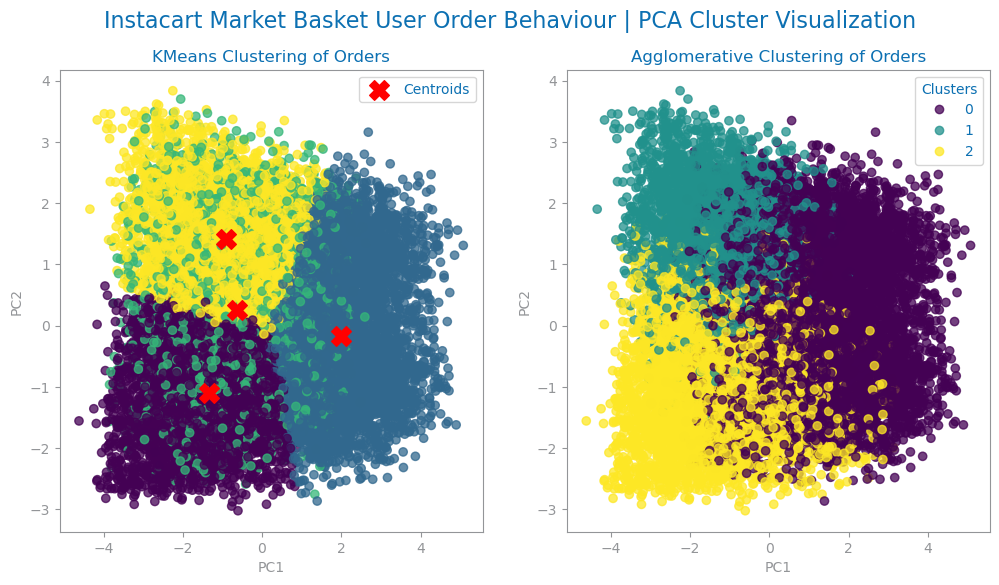

In [207]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
scatter_kmeans = plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.75)
kmeans_centroids = pca_reorder.transform(reorder_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering of Orders')
plt.legend(*scatter_kmeans.legend_elements(), title="Clusters")
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
scatter_agglo = plt.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.75)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering of Orders')
plt.legend(*scatter_agglo.legend_elements(), title="Clusters")

plt.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

### PCA Plot 3D

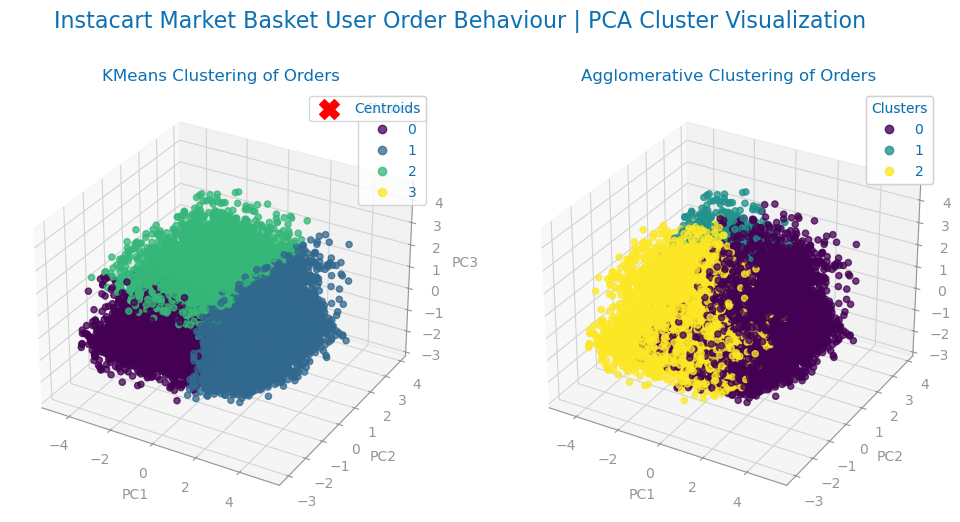

In [208]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
scatter_kmeans = ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_kmeans, cmap='viridis', alpha=0.75)
kmeans_centroids_3d = pca_reorder.transform(reorder_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering of Orders')
legend1 = ax.legend(*scatter_kmeans.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
scatter_agglo = ax.scatter(pca_reorder_df['PC1'], pca_reorder_df['PC2'], pca_reorder_df['PC3'], c=reorder_y_pred_agglo, cmap='viridis', alpha=0.75)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering of Orders')
legend2 = ax.legend(*scatter_agglo.legend_elements(), title="Clusters")
ax.add_artist(legend2)

fig.suptitle(f"{file_tag} User Order Behaviour | PCA Cluster Visualization", fontsize=16)

plt.show()

# outputs
